In [70]:
import argparse
import cv2
import numpy
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import ndimage

from demo import Demonstration
from trainer import Trainer

%matplotlib inline

In [71]:
def read_image(path: str, img_type: str):
    """
    Reads image into numpy array
    @param path: Path to image
    @param img_type: One of 'color', 'depth'
    @return: Array containing image contents
    """
    # This is repeated several times in the code and should ideally be refactored into a function

    if img_type == "color":
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    elif img_type == "depth":
        return numpy.stack([cv2.imread(path, -1)]*3, axis=-1).astype(numpy.float32)/100000
    return None

In [72]:
# Workspace limits
workspace_limits = numpy.asarray([[-0.724, -0.276], [-0.224, 0.224], [-0.0001, 0.5]])

# Test images
test_color_heightmap = read_image("logs/2020-06-07-16-31-33_Real-Stack-Two-Step-Reward-Masked-Testing/data/color-heightmaps/000004.0.color.png", 'color')
test_depth_heightmap = read_image("logs/2020-06-07-16-31-33_Real-Stack-Two-Step-Reward-Masked-Testing/data/depth-heightmaps/000004.0.depth.png", 'depth')

# Demo files
demo = Demonstration("logs/vertical_square_demos", 1, None)
demo_color_heightmap, demo_depth_heightmap = demo.get_heightmaps("grasp", 12, use_hist=True)


# stack_snapshot_file = 'logs/base_models/rows_hist_densenet/snapshot.reinforcement_action_efficiency_best_value.pth'
# stack_snapshot_file = 'logs/base_models/stacking_hist_densenet/snapshot.reinforcement_action_efficiency_best_value.pth'
# stack_snapshot_file = 'logs/base_models/unstacking_hist_densenet/snapshot.reinforcement_action_efficiency_best_value.pth'
stack_snapshot_file = 'logs/base_models/vertical_square_hist_densenet/snapshot.reinforcement_trial_success_rate_best_value.pth'

stack_trainer = Trainer(method='reinforcement', push_rewards=True, future_reward_discount=0.5,
                        is_testing=True, snapshot_file=stack_snapshot_file,
                        force_cpu=False, goal_condition_len=0, place=True,
                        pretrained=True, flops=False, network='densenet',
                        common_sense=True, place_common_sense=True,
                        show_heightmap=False, place_dilation=0.01,
                        common_sense_backprop=True, trial_reward='spot',
                        num_dilation=0)

CUDA detected. Running with GPU acceleration.


/home/absox/PycharmProjects/real_good_robot/venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Pre-trained model snapshot loaded from: logs/base_models/vertical_square_hist_densenet/snapshot.reinforcement_trial_success_rate_best_value.pth


In [73]:
# get demo action index vector
action_vector = demo.action_dict[3][1]

# convert rotation angle to index
best_rot_ind = numpy.around((numpy.rad2deg(action_vector[-2]) % 360) * 16 / 360).astype(int)
# test_rot_ind = 15

# convert robot coordinates to pixel
workspace_pixel_offset = workspace_limits[:2, 0] * -1 * 1000
best_action_xy = ((workspace_pixel_offset + 1000 * action_vector[:2]) / 2).astype(int)

print(best_action_xy)
print(best_rot_ind)

[204  76]
7


In [74]:
_, demo_features, _ = stack_trainer.forward(demo_color_heightmap, demo_depth_heightmap,
                                            is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]
demo_features = demo_features.filled(0.0)

In [75]:
_, test_features , _ = stack_trainer.forward(test_color_heightmap, test_depth_heightmap,
                                            is_volatile=True, keep_action_feat=True, demo_mask=True)[:3]
test_features = test_features.filled(0.0)


In [76]:
demo_features_rot = demo_features[best_rot_ind,:,:,:]
# test_features_rot = test_features[test_rot_ind,:,:,:]

# Compute mask
demo_mask = (demo_features_rot == 0).all(axis=0)
# test_mask = (test_features_rot == 0).all(axis=0)
test_mask = (test_features==0).all(axis=1)

In [77]:
# match_dist = numpy.zeros([16, 224, 224])
match_dist = numpy.sum(numpy.square(numpy.expand_dims(demo_features_rot[:, best_action_xy[1], best_action_xy[0]],(0,2,3)) - test_features), axis=1)
match_dist[test_mask] = numpy.max(match_dist)
matched_action = numpy.unravel_index(numpy.argmin(match_dist), (16, 224, 224))

test_rot_ind = matched_action[0]
test_features_rot = test_features[test_rot_ind,:,:,:]
test_mask_rot = test_mask[test_rot_ind,:,:]

(11, 56, 119)


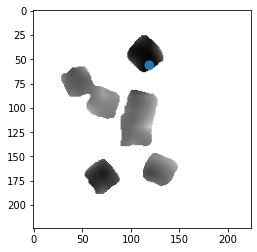

In [78]:
fig, ax = plt.subplots(1)
ax.imshow(match_dist[test_rot_ind,:,:], cmap="gray")

circle = Circle((matched_action[2], matched_action[1]))
ax.add_patch(circle)
print(matched_action)

In [79]:
rematch_squared_distance = numpy.zeros([224, 224])

for i in range(0, 224):
    for j in range(0, 224):
        x = numpy.expand_dims(test_features_rot[:,i,j], (1,2))
        displacement = demo_features_rot - x
        distances = numpy.sum(numpy.square(displacement), axis=0)
        distances = ndimage.gaussian_filter(distances, sigma=(3,3))
        distances[demo_mask] = numpy.max(distances) * 1.1
        match_index = numpy.unravel_index(numpy.argmin(distances), (224, 224))
        rematch_squared_distance[i,j] = numpy.sum(numpy.square(match_index - best_action_xy[[1, 0]]))

rematch_distance = numpy.sqrt(rematch_squared_distance)

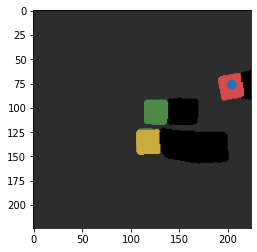

In [80]:
fig, ax = plt.subplots(1)

ax.imshow(demo_color_heightmap)
circle = Circle(best_action_xy)
ax.add_patch(circle)
# fig, ax = plt.imshow(demo_color_heightmap)


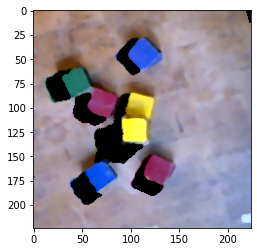

In [81]:
plt.imshow(test_color_heightmap)

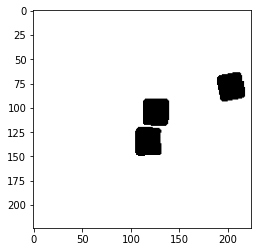

In [82]:
plt.imshow(demo_mask, cmap='gray')

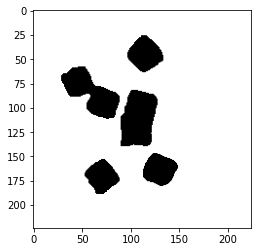

In [83]:
plt.imshow(test_mask_rot, cmap='gray')

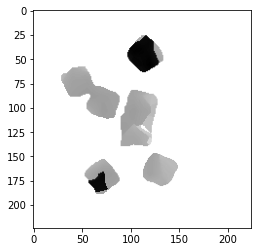

In [84]:
rematch_distance[test_mask_rot] = numpy.max(rematch_distance)
plt.imshow(rematch_distance, cmap='gray')

In [85]:
inverse_heights = numpy.max(rematch_distance) - rematch_distance
inverse_heights[test_mask_rot] = 0
# inverse_heights[~test_mask] = 200


True

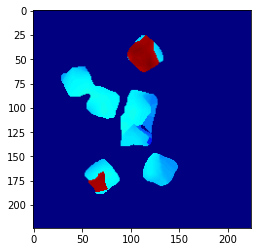

In [86]:
inverse_heights_image = cv2.applyColorMap(((1-inverse_heights/numpy.max(inverse_heights))*255).astype(numpy.uint8), cv2.COLORMAP_JET)
plt.imshow(inverse_heights_image)

inverse_heights_image_reverse = cv2.applyColorMap(((inverse_heights/numpy.max(inverse_heights))*255).astype(numpy.uint8), cv2.COLORMAP_JET)
# cv2.imwrite("figures/inverse_heights_row.png", inverse_heights_image_reverse)
# cv2.imwrite("figures/inverse_heights_stack.png", inverse_heights_image_reverse)
# cv2.imwrite("figures/inverse_heights_unstack.png", inverse_heights_image_reverse)
cv2.imwrite("figures/inverse_heights_square.png", inverse_heights_image_reverse)

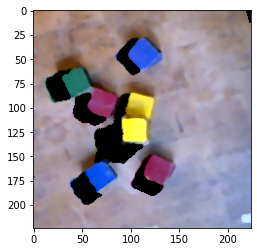

In [87]:
plt.imshow(test_color_heightmap)

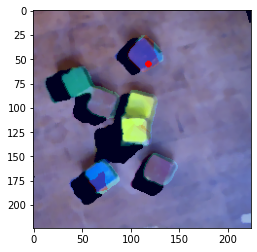

In [88]:
# Compute colors
# colors = [test_color_heightmap[i,j,:]/255 for j in range(0, 224) for i in range(0, 224)]
x = [i for j in range(0, 224) for i in range(0, 224)]
y = [j for j in range(0, 224) for i in range(0, 224)]
top = [inverse_heights[i,j] for j in range(0, 224) for i in range(0, 224)]

best_test_action_index = numpy.argmax(top)
best_test_action = (y[best_test_action_index], x[best_test_action_index])
# inverse_heights_image = cv2.circle(inverse_heights_image, best_test_action, 2, (255, 0, 0), 2)
blended = cv2.addWeighted(inverse_heights_image, 0.25, test_color_heightmap, 0.75, 0)


blended = cv2.circle(blended, best_test_action, 2, (255, 0, 0), 2)
plt.imshow(blended)

colors = [blended[i,j,:]/255 for j in range(0, 224) for i in range(0, 224)]
# _x = numpy.arange(224)
# _y = numpy.arange(224)
# _xx, _yy = numpy.meshgrid(_x, _y)
# x, y = _xx.ravel(), _yy.ravel()

# top = inverse_heights.flatten('C')
bottom = numpy.zeros(len(top))

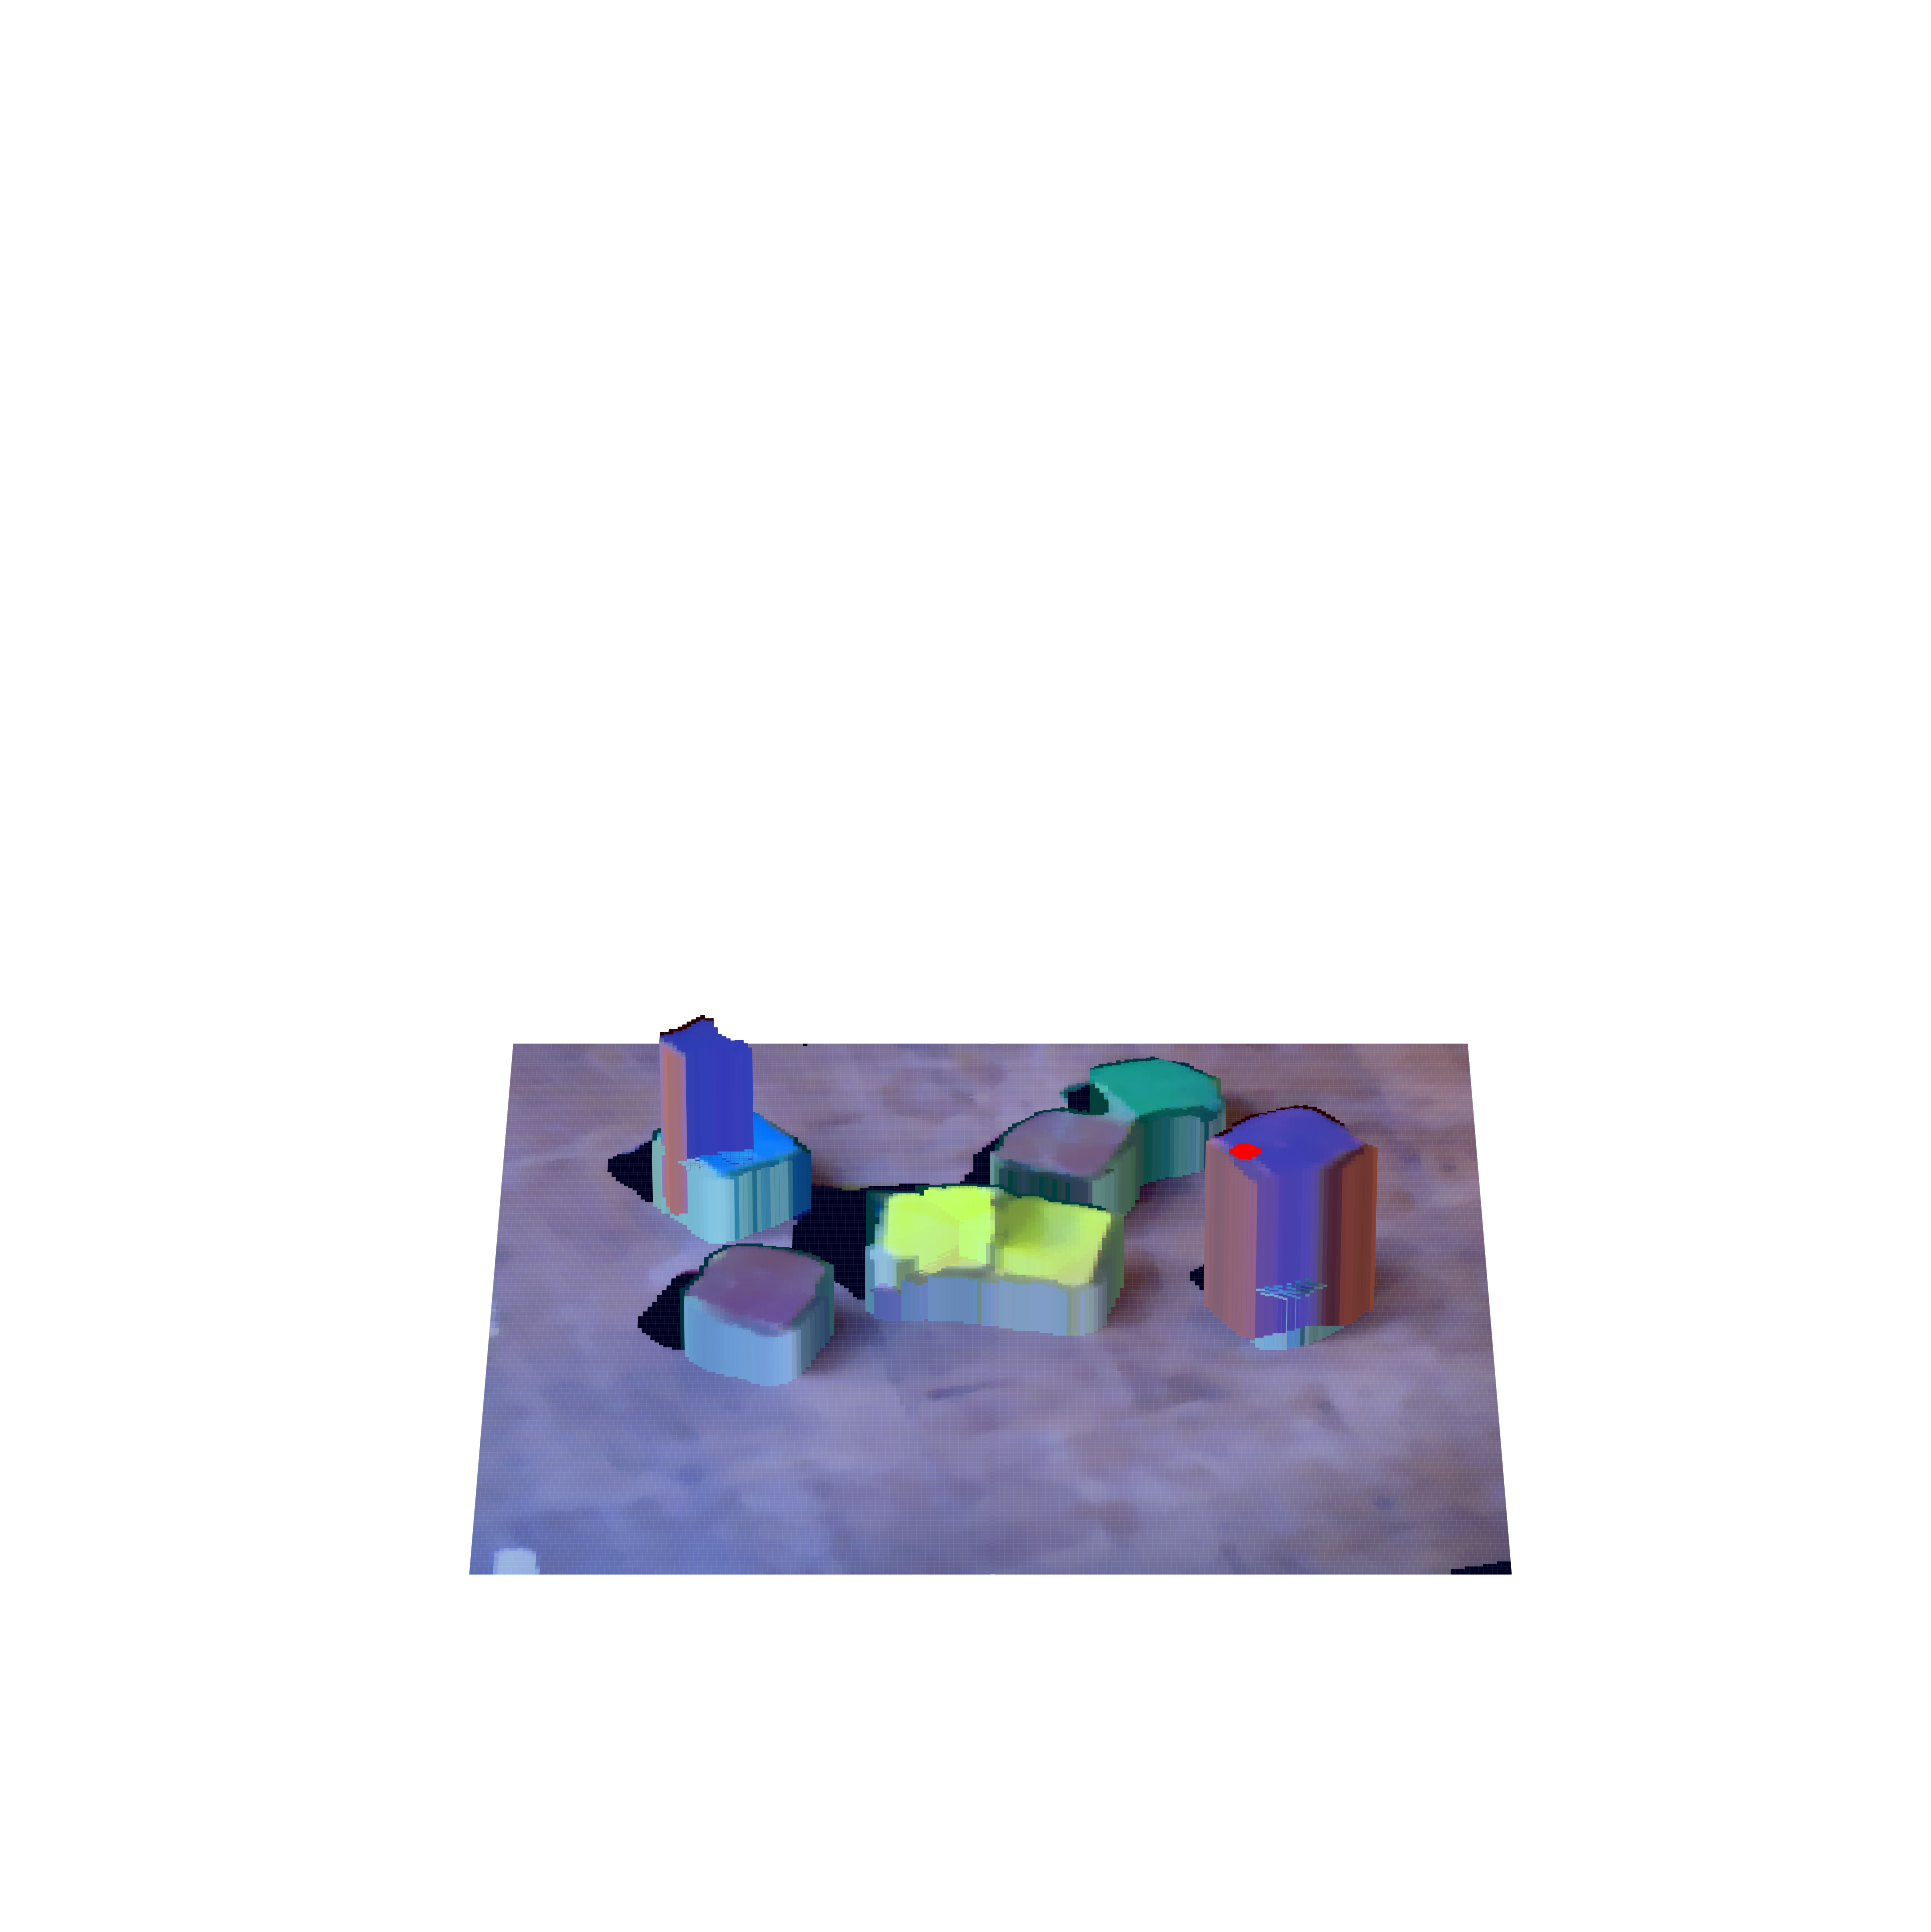

In [89]:
figure = plt.figure(figsize=(6, 4), dpi=600)
ax = figure.add_subplot(111, projection='3d')
ax.view_init(elev=30., azim=90)
# ax.view_init(elev=30., azim=0)

# ax.plot_surface(numpy.array(x), numpy.array(y), numpy.array(top), color=colors)
ax.bar3d(x, y, bottom, 1, 1, top, shade=False, color=colors)

ax.set_zlim(0, 500)

plt.axis('off')

plt.show()

In [90]:
# figure.savefig("figures/test_cc_figure_7_row.png", transparent=True)
# figure.savefig("figures/test_cc_figure_7_stack.png", transparent=True)
# figure.savefig("figures/test_cc_figure_7_unstack.png", transparent=True)
figure.savefig("figures/test_cc_figure_7_square.png", transparent=True)

116.22075610134759
0.0
True
(118, 55)


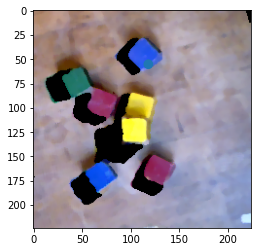

In [91]:
masked_test_color_heightmap = test_color_heightmap.copy()
masked_test_color_heightmap[test_mask_rot,:] = 0
# best_test_action = numpy.unravel_index(numpy.argmin(rematch_distance), (224, 224))
best_test_action_index = numpy.argmax(top)
best_test_action = (y[best_test_action_index], x[best_test_action_index])
print(numpy.max(top))
print(inverse_heights[best_test_action])
print(test_mask_rot[best_test_action])
print(best_test_action)

fig, ax = plt.subplots(1)

# ax.imshow(masked_test_color_heightmap)
# ax.imshow(inverse_heights, cmap='gray')
ax.imshow(test_color_heightmap)
# ax.imshow(test_mask)
ax.add_patch(Circle(best_test_action))



In [92]:
# TODO:
# Check rotation
# Tighter mask - N/A
# Subtract minimum nonzero value - done
# Try adding the match distance
# Save image files for figures - done
# Refactor